In [14]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import tensorflow as tf
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from PIL.Image import BILINEAR
from multiprocessing import Process, freeze_support, set_start_method

import argparse
import numpy as np
import time
import uuid
import os
import sys
from importlib import reload

from models.resnet import *
import augment


import util
from logger import Logger
from custom_dataset import MultiViewDataSet

Number of GPUs:  1


In [2]:
parser = argparse.ArgumentParser(description='MVCNN-PyTorch')
parser.add_argument('--data', metavar='DIR', default='/localscratch/Users/amotahari/MV_CNN_views', help='path to dataset')
parser.add_argument('-j', '--job_id', metavar='ID', default='', help='SGE job ID')
parser.add_argument('--resnet', default=18, choices=[18, 34, 50, 101, 152], type=int, metavar='N', help='resnet depth (default: resnet18)')
parser.add_argument('--epochs', default=10000, type=int, metavar='N', help='number of total epochs to run (default: 100)')
parser.add_argument('-b', '--batch-size', default=22, type=int,
                    metavar='N', help='mini-batch size (default: 4)')
parser.add_argument('--lr', '--learning-rate', default=0.00001, type=float,
                    metavar='LR', help='initial learning rate (default: 0.01)')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum (default: 0.9)')
parser.add_argument('--lr-decay-freq', default=200, type=float,
                    metavar='W', help='learning rate decay (default: 30)')
parser.add_argument('--lr-decay', default=0.5, type=float,
                    metavar='W', help='learning rate decay (default: 0.1)')
parser.add_argument('--print-freq', '-p', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('-r', '--resume', default='/Shared/CTmechanics_COPDGene/Amin/Airway_PyTorch/607310/checkpoint.pth.tar', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('-o', '--output', default='/Shared/CTmechanics_COPDGene/Amin/Airway_PyTorch', type=str, metavar='PATH',
                    help='path to Output folder for logs and checkpoints (default: none)')
parser.add_argument('-w', '--workers', default=1, type=int,
                    metavar='N', help='Number of workers in input pipe (default: 4)')
parser.add_argument('-wd', '--weight_decay', default=0.0, type=float,
                    metavar='W', help='Weight decay factor (default: 0.1)')

parser.add_argument('--mode', default='test', type=str,
                    metavar='M', help='Operating mode (default: train)')

parser.add_argument('-f', '--fun', default='', type=str, metavar='PATH',
                    help='path to Output folder for logs and checkpoints (default: none)')
#parser.add_argument('--pretrained', dest='pretrained', action='store_true', help='use pre-trained model')

args = parser.parse_args()


In [3]:
transform = transforms.Compose([
    #transforms.CenterCrop(500),
    #transforms.RandomAffine(30, translate=(.2,.2), scale=None, shear=None, resample=BILINEAR, fillcolor=0), # Augmentation
    transforms.Resize(224),
    transforms.ToTensor(),
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Loading data')
if args.mode=='test':
    dset_test = MultiViewDataSet(args.data, 'test', transform=transform)
    print("\nTest Data Loaded!")
else:
    dset_train = MultiViewDataSet(args.data, 'train', transform=transform)
    print("\nTraining Data Loaded!")
    dset_val = MultiViewDataSet(args.data, 'validation', transform=transform)
    print("\nValidation Data Loaded!")

Loading data
/localscratch/Users/amotahari/MV_CNN_views/sets/test.txt
Loading test data: 100% 
Test Data Loaded!


In [4]:
if args.mode=='test':
    test_loader = DataLoader(dset_test, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)
else:
    val_loader = DataLoader(dset_val, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
    train_loader = DataLoader(dset_train, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)

Jupyter_Thu_Oct_18_13_58_27_2018
3 ['Standard', 'AccB', 'AbsRB7']
Using resnet18
CUDA devices available:  range(0, 1)
Running on cuda:0

==> Loading checkpoint..
Number of GPUs:  1
Testing:
0.0
0.889657
0.0
0.851931
0.0
0.924311
0.0
0.893816
0.0
0.90106
0.0
0.87451
0.0
0.870008
0.0
0.864623
0.0
0.993768
0.0
0.834971
0.0
0.886004
0.0
0.90884
0.0
0.899332
0.0
0.909593
0.0
0.901001
0.0
0.900896
0.0
0.894121
0.0
0.917314
0.0
0.89785
0.0
0.880388
0.0
0.916886
0.0
0.834009
	Val Acc: 40.00 - Loss: 1.0908

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x2ae03f442cc0>>
Traceback (most recent call last):
  File "/opt/apps/pytorch/0.4.0_cuda-9.0.176.1_python-3.6.4/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/opt/apps/pytorch/0.4.0_cuda-9.0.176.1_python-3.6.4/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/opt/apps/python/3.6.4/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/opt/apps/pytorch/0.4.0_cuda-9.0.176.1_python-3.6.4/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/apps/python/3.6.4/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/opt/apps/python/3


	Current best val acc: 79.00


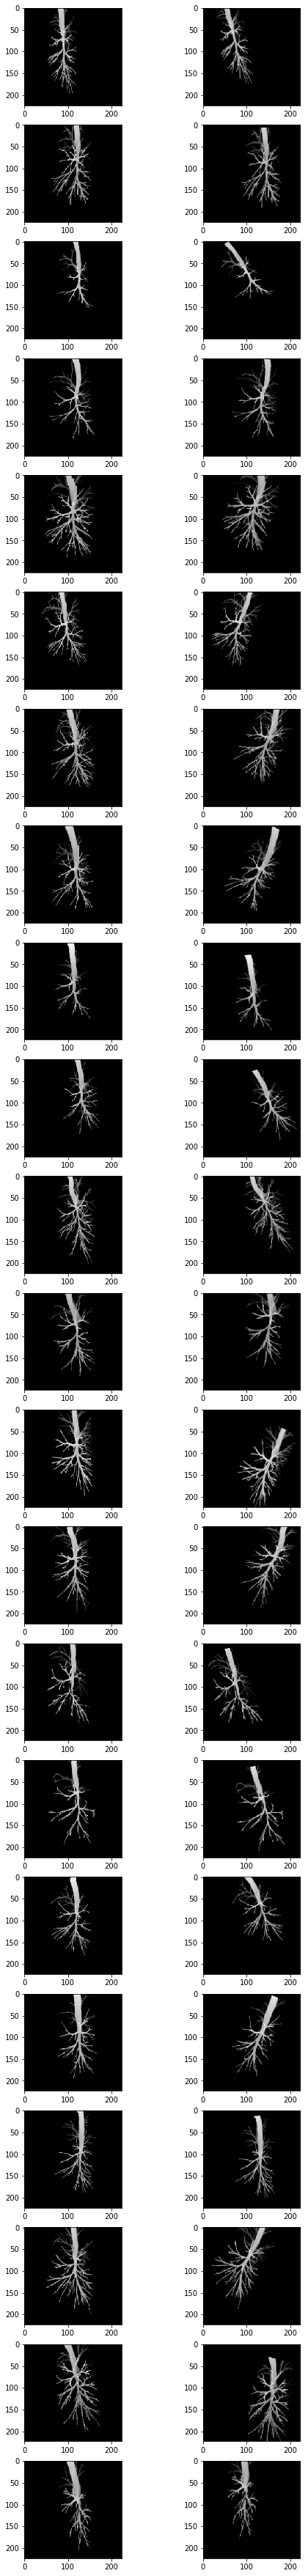

In [24]:
#torch.cuda.empty_cache()

if args.job_id =='':
    job_folder = "Jupyter_"+time.asctime( time.localtime(time.time()) )#str(uuid.uuid4().hex)[:5]
    job_folder = job_folder.replace(' ','_').replace(':','_')
else:
    job_folder = args.job_id

print(job_folder)

args.output = os.path.join(args.output, job_folder)
if not os.path.exists(args.output):
    os.makedirs(args.output)

with open(os.path.join(args.output,'Arguments.txt'), "w") as text_file:
    print(args, file = text_file) #text_file.write(args)
    
classes = dset_train.classes

print(len(classes), classes)

if args.resnet == 18:
    resnet = resnet18(num_classes=len(classes))
elif args.resnet == 34:
    resnet = resnet34(num_classes=len(classes))
elif args.resnet == 50:
    resnet = resnet50(num_classes=len(classes))
elif args.resnet == 101:
    resnet = resnet101(num_classes=len(classes))
elif args.resnet == 152:
    resnet = resnet152(num_classes=len(classes))

print('Using resnet' + str(args.resnet))
resnet.to(device)
device_ids = range(torch.cuda.device_count())
print("CUDA devices available: ",device_ids)
resnet = nn.DataParallel(resnet, device_ids=device_ids)
cudnn.benchmark = True

print('Running on ' + str(device))

logger = Logger(os.path.join(args.output, 'logs'))

# Loss and Optimizer
lr = args.lr
n_epochs = args.epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr, weight_decay=args.weight_decay)

best_acc = 0.0
best_loss = 0.0
start_epoch = 0

# Helper functions
def load_checkpoint():
    global best_acc, start_epoch
    # Load checkpoint.
    print('\n==> Loading checkpoint..')
    assert os.path.isfile(args.resume), 'Error: no checkpoint file found!'

    checkpoint = torch.load(args.resume)
    best_acc = checkpoint['best_acc']
    start_epoch = checkpoint['epoch']
    resnet.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])


def train():
    train_size = len(train_loader)

    for i, (inputs, targets) in enumerate(train_loader):
        # Convert from list of 3D to 4D
        #inputs = np.stack(inputs, axis=1)
        #inputs = np.stack(inputs, axis=0)
        inputs = augment.augment_on_GPU(inputs)

        #print("shape of Train input= ", inputs.shape)        
        #inputs = augment_on_GPU(inputs)
        inputs = torch.from_numpy(inputs)
        #print("shape of Train input from numpy= ", inputs.shape)  
        inputs, targets = inputs.cuda(), targets.cuda(0)
        inputs, targets = Variable(inputs), Variable(targets)
        
        # compute output
        outputs = resnet(inputs)
        #print(outputs.get_device(), targets.get_device())

        loss = criterion(outputs, targets)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % args.print_freq == 0:
            print("\tIter [%d/%d] Loss: %.4f" % (i + 1, train_size, loss.item()))


# Validation and Testing
def eval(data_loader, is_test=False):
    if is_test:
        load_checkpoint()

    # Eval
    total = 0.0
    correct = 0.0

    total_loss = 0.0
    n = 0

    for i, (inputs, targets) in enumerate(data_loader):
        with torch.no_grad():
            # Convert from list of 3D to 4D
            #inputs = np.stack(inputs, axis=0)
            inputs = augment.augment_on_GPU(inputs)
            
            #print("shape of Val input= ", inputs.shape)
            #inputs = augment_on_GPU(inputs)
            inputs = torch.from_numpy(inputs)

            inputs, targets = inputs.cuda(), targets.cuda(0)
            inputs, targets = Variable(inputs), Variable(targets)

            # compute output
            outputs = resnet(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss
            n += 1

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted.cpu() == targets.cpu()).sum()

    avg_test_acc = 100 * correct / total
    avg_loss = total_loss / n

    return avg_test_acc, avg_loss

def test(data_loader):
    resnet.eval()
    # Eval
    total = 0.0
    correct = 0.0

    total_loss = 0.0
    n = 0

    for i, (inputs, targets) in enumerate(data_loader):
        with torch.no_grad():
            # Convert from list of 3D to 4D
            #inputs = np.stack(inputs, axis=0)
            A = inputs
            inputs = augment.augment_on_GPU(inputs)
            #print("shape of Val input= ", inputs.shape)
            #inputs = augment_on_GPU(inputs)
            inputs = torch.from_numpy(inputs)
            inputs, targets = inputs.cuda(), targets.cuda(0)
            inputs, targets = Variable(inputs), Variable(targets)

            # compute output
            outputs = resnet(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss
            n += 1

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted.cpu() == targets.cpu()).sum()
            
            
            plt.figure(figsize=(8, 64))
            
            for i in range(args.batch_size):
                B = A[i,0,:].transpose(0, 2)
                I1 = B.transpose(0,1)
                I = inputs.cpu()
                B = I[i,0,:].transpose(0, 2)
                I2 = B.transpose(0,1)
                I2 = (I2.data.numpy()) 
                
                print(np.amin(I2))
                print(np.amax(I2))
                plt.subplot(args.batch_size,2,2*i+1)
                plt.imshow(I1)
                plt.subplot(args.batch_size,2,2*i+2)
                plt.imshow(I2)
            break
            
            
    avg_test_acc = 100 * correct / total
    avg_loss = total_loss / n

    return avg_test_acc, avg_loss

# Training / Eval loop
if args.resume or args.mode == 'test':
    load_checkpoint()

reload(augment)
    
if args.mode == 'test':
    print('Testing:')
    avg_test_acc, avg_loss = test(test_loader)
    print('\tVal Acc: %.2f - Loss: %.4f' % (avg_test_acc.item(), avg_loss.item()))
    print('\tCurrent best val acc: %.2f' % best_acc)    
    
else:
    for epoch in range(start_epoch, n_epochs):
        print('\n-----------------------------------')
        print('Epoch: [%d/%d]' % (epoch+1, n_epochs))
        start = time.time()

        resnet.train()
        train()
        print('Time taken: %.2f sec.' % (time.time() - start))
        if (epoch + 1) % 5 == 0: # Eval every 5 epoch
            resnet.eval()
            avg_test_acc, avg_loss = eval(val_loader)

            print('\nEvaluation:')
            print('\tVal Acc: %.2f - Loss: %.4f' % (avg_test_acc.item(), avg_loss.item()))
            print('\tCurrent best val acc: %.2f' % best_acc)

            # Log epoch to tensorboard
            # See log using: tensorboard --logdir='logs' --port=6006
            util.logEpoch(logger, resnet, epoch + 1, avg_loss, avg_test_acc)

            # Save model
            if avg_test_acc > best_acc:
                print('\tSaving checkpoint - Acc: %.2f' % avg_test_acc)
                best_acc = avg_test_acc
                best_loss = avg_loss
                util.save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': resnet.state_dict(),
                    'acc': avg_test_acc,
                    'best_acc': best_acc,
                    'optimizer': optimizer.state_dict(),
                    },
                    checkpoint = args.output
                )

        # Decaying Learning Rate
        if (epoch + 1) % args.lr_decay_freq == 0:
            lr *= args.lr_decay
            optimizer = torch.optim.Adam(resnet.parameters(), lr=lr, weight_decay=args.weight_decay)
            print('Learning rate:', lr)

In [12]:
#Check input pipeline throughput
start = time.time()
for i, (inputs, targets) in enumerate(train_loader):
    #inputs = augment.augment_on_GPU(inputs)
    if i==0:
        print("Input tensor shape: ",inputs.shape)
    
    sys.stdout.write('Reading batch {} of {} \r'.format(i+1,len(train_loader)))
    sys.stdout.flush()
#    if i==10:
#        break
print('\nTime to read one epoch:  %.2f seconds.' % (time.time() - start))

NameError: name 'train_loader' is not defined

In [ ]:
print(inputs[0:2,:].shape)

A = augment_on_GPU(inputs)
A = torch.from_numpy(A)
print(A.shape)

In [ ]:
print(inputs[0,0,:].shape)

C = A-inputs
B = C[0,5,:].transpose(0, 2)
B = B.transpose(0,1)
plt.imshow(B)


In [26]:
!jupyter nbconvert --to script interactive_controller.ipynb --output controller

[NbConvertApp] Converting notebook interactive_controller.ipynb to script
[NbConvertApp] Writing 13078 bytes to controller.py


In [ ]:
torch.cuda.empty_cache()


In [ ]:
import subprocess
A = str(subprocess.check_output(["{job_id}"]))
print("s = ",A)
#print(subprocess.call("nvidia-smi"))